In [1]:
#simulations infrastructure
import splat
import wisps.simulations as wispsim
from astropy.coordinates import SkyCoord

import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import wisps
import pandas as pd

import seaborn as sns
%matplotlib inline
import splat.photometry as sphot
import splat.core as spl
import splat.empirical as spe
import splat.simulate as spsim
import matplotlib as mpl
from tqdm import tqdm

#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.9
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.bottom']=True
mpl.rcParams['xtick.major.width']=0.9
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['ytick.major.width']=0.9
mpl.rcParams['ytick.minor.width']=0.9
mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'


from astropy import stats as astrostats

In [2]:
def fit_polynomial(x, y, n=2, sigma=5, y_unc=None):
    va=np.array([x, y]).T
    print (va.shape)
    d=pd.DataFrame(va).dropna().values
    print (d.shape)
    sigma_clipped=astrostats.sigma_clip(d, sigma=sigma)

    p = np.poly1d(np.polyfit(sigma_clipped[:, 0], sigma_clipped[:, 1], n))
 
    return p

def dropnans(x):
    return [~np.isnan(x)]

In [3]:
grid=np.sort(np.random.uniform(1000, 4000,1000))

In [4]:
#plt.plot(grid, splat_teff_to_spt(grid))
#plt.xlim(10, 40)

### Generate a spectral type, HST mags relation <br>
Using spex templates/standards


In [5]:
kirkpa2019pol={'pol':np.poly1d(np.flip([36.9714, -8.66856, 1.05122 ,-0.0344809])), 
                'scatter':.67, 'range':[36, 44]}

In [6]:
def absolute_mag_dupuy(spt, filt):
    #use the uncertainty in dupuy relation 
    val, unc=spe.typeToMag(spt,filt,set='dupuy')
    return np.random.normal(val, unc)

def absolute_mag_kirkpatrick(spt, filt):
    if filt != '2MASS H':
        return np.nan
    else:
        if (spt > 36) and (spt <44):
            pol=kirkpa2019pol['pol']
            unc=kirkpa2019pol['scatter']
            return np.random.normal(pol(spt-30), unc)
            
        else:
            return np.nan
        
def absolute_mag_relation(spt, filt):
    spt=wisps.make_spt_number(spt)
    #try dupuy up to T7
    if spt < 37:
        return absolute_mag_dupuy(spt, filt)
    else: 
        return absolute_mag_kirkpatrick(spt, filt)
    

In [7]:
def flux_calibrate_spectrum(filename):
    try:
        sp=splat.getSpectrum(filename=filename)[0]
        spt=splat.typeToNum(sp.spex_type)
        sp.fluxCalibrate('2MASS J',float(sp.j_2mass))
        return [spt, sp]
    except:
        return []

In [8]:
def schn_flux_calibrate(row):
    sp=row.spectra.splat_spectrum
    spt=splat.typeToNum(row.Spec)
    sp.fluxCalibrate('MKO J',float(row.J_MKO))
    return [spt, sp]

In [9]:
splat_db=splat.searchLibrary(vlm=True, giant=False, young=False)

In [10]:
schn_ydwarfs=pd.read_pickle(wisps.LIBRARIES+'/schneider.pkl')

In [11]:
sml=splat_db[(~ splat_db.PARALLAX.isna())]
calbr=sml.DATA_FILE.apply(flux_calibrate_spectrum)


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file


Retrieving 1 file



In [12]:
calbrschn=schn_ydwarfs.apply(schn_flux_calibrate, axis=1)

In [13]:
combcal=np.append(calbr, calbrschn)

In [14]:
specs=np.array([x for x in pd.DataFrame(combcal).values if x])

In [46]:
#transform dupuy relation into HST mags
def get_colors(sp, flt):
    #using splat filtermag
    mag, mag_unc = splat.filterMag(sp, flt)
    #calculate the mag of the standard in J and H
    magj, mag_uncj = splat.filterMag(sp,'2MASS J')
    magh, mag_unch = splat.filterMag(sp,'2MASS H')
    #calculate the offset between HST filters and 2mass filters but add the uncertainty
    
    magjtouse=np.random.normal(magj,  mag_uncj)
    maghtouse=np.random.normal(magh,  mag_unch)
    offsetj=magjtouse-mag
    offseth=maghtouse-mag
    return [offsetj, offseth]

In [16]:
def get_abs_hst_mag(color, mag0):
    return mag0-color

In [17]:
#specs

In [18]:
colors=[]
absmags=[]
fltrs= ['WFC3_{}'.format(k) for k in ['F110W', 'F140W', 'F160W']]
for pair in tqdm(specs):
    c=[]
    for flt in fltrs:
        x=pair[0][1]
        color=get_colors(x, flt)
        c.append(color)
    colors.append(c)
#abs_hstmags=[get_abs_hst_mag(splat.typeToNum(x)) for x in  sp_grid]

100%|██████████| 343/343 [04:03<00:00,  1.41it/s]


In [19]:
colors=np.array(colors)

In [20]:
spts=np.array([pair[0][0] for pair in specs])

In [21]:
spgrididx=np.argsort(spts)
sp_grid=spts[spgrididx]
colors=colors[spgrididx]

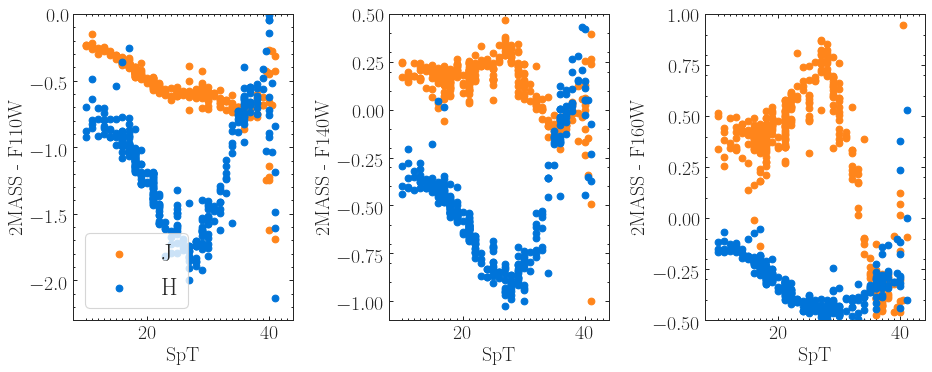

In [45]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 5), sharey=False)
for a in ax:
    a.set_xlabel('SpT')

ax[0].set_ylabel('2MASS - F110W')
ax[0].scatter(sp_grid, colors[:,0][:,0], label='J',linestyle='-', c='#FF851B')
ax[0].scatter(sp_grid, colors[:,0][:,1], label='H',linestyle='-', c='#0074D9')

ax[1].set_ylabel('2MASS - F140W')
ax[1].scatter(sp_grid, colors[:,1][:,0], label='J',linestyle='-', c='#FF851B')
ax[1].scatter(sp_grid, colors[:,1][:,1], label='H',linestyle='-', c='#0074D9')

ax[2].set_ylabel('2MASS - F160W')
ax[2].scatter(sp_grid, colors[:,2][:,0], label='J',linestyle='-', c='#FF851B')
ax[2].scatter(sp_grid, colors[:,2][:,1], label='H',linestyle='-', c='#0074D9')

ax[0].legend()

for a in ax:
    a.set_xticks(np.arange(10, 45, 1), minor=True)
    a.set_yticks(np.arange(-3, 1.0, 0.1), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_ylim([-2.3, 0.0])
ax[1].set_ylim([-1.1, 0.5])
ax[2].set_ylim([-0.5, 1.0])
plt.tight_layout()
plt.savefig(wisps.OUTPUT_FIGURES+'/mass_hubble_colors.pdf')

### Generate apparent HST mags<br>
Using candidates?

In [23]:
absolute_mag_dupuy(40, '2MASS H')

nan

In [24]:
absolute_mag_kirkpatrick(40, '2MASS H')

22.417235566918723

In [25]:
js = [absolute_mag_relation(x, '2MASS J') for x in sp_grid]
hs= [absolute_mag_relation(x, '2MASS H') for x in sp_grid]

In [26]:
abs_hstmagsj=np.array([np.array(js)-x for x  in colors[:, :,0].T]).T
abs_hstmagsh=np.array([np.array(hs)-x for x  in colors[:, :,0].T]).T

In [27]:
def get_app_hst_mag(dist, absmag):
    ##returns apparent HST mag given distance and absolute mag
    return np.log10(dist-1)*5+absmag

In [28]:
#app_hstmags=[]
#for m in np.array(abs_hstmags)[:,:, 0]:
#    app_hstmags.append([get_app_hst_mag(ds, x) for x in  m])

In [29]:
avg_f110=np.nanmean([abs_hstmagsj[:,0], abs_hstmagsh[:,0]], axis=0)
avg_f140=np.nanmean([abs_hstmagsj[:,1], abs_hstmagsh[:,2]], axis=0)
avg_f160=np.nanmean([abs_hstmagsj[:,2], abs_hstmagsh[:,2]], axis=0)

In [30]:
abs_hstmags=np.array([avg_f110, avg_f140, avg_f160])

#app_hstmags=[]
#for m in np.array(abs_hstmags):
#    app_hstmags.append([get_app_hst_mag(ds, x) for x in  m])

## Visualization

(343, 2)
(277, 2)
(343, 2)
(277, 2)
(343, 2)
(314, 2)


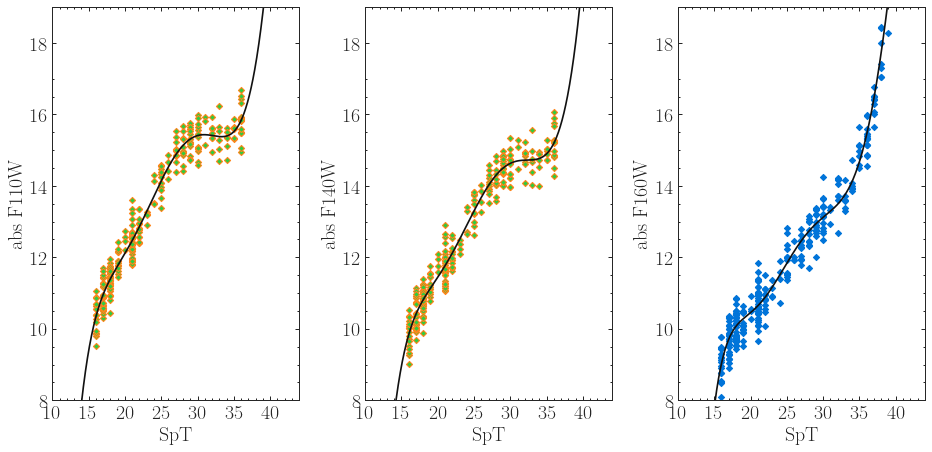

In [31]:
fig, ax=plt.subplots(ncols=3, sharey=False, figsize=(12, 6))
for a in ax:
    a.set_xlabel('SpT')

#ax[0].plot( sp_grid, np.array(js))
#ax[1].plot( sp_grid, np.array(hs))

#ax[0].set_ylabel('abs J')
#ax[1].set_ylabel('abs H')

ax[0].scatter( sp_grid, abs_hstmagsj[:,0], facecolor='#2ECC40',  edgecolor='#FF851B', s=15, marker='D')#, linestyle=':')
ax[1].scatter( sp_grid, abs_hstmagsj[:,1], facecolor='#2ECC40',  edgecolor='#FF851B', s=15, marker='D')#, linestyle=':')
#ax[2].scatter( sp_grid, abs_hstmagsj[:,2], facecolor='None',  edgecolor='#FF851B', alpha=0.1, s=15, marker='D')#, linestyle=':')

#ax[0].scatter( sp_grid, abs_hstmagsh[:,0],facecolor='None',  edgecolor='#0074D9', alpha=0.1, s=15, marker='D')
#ax[1].scatter(sp_grid, abs_hstmagsh[:,1], facecolor='None',  edgecolor='#0074D9', alpha=0.1, s=15, marker='D')
ax[2].scatter( sp_grid, abs_hstmagsh[:,2], facecolor='#0074D9',  edgecolor='#0074D9', s=15, marker='D')

ax[0].set_ylabel('abs F110W')
ax[1].set_ylabel('abs F140W')
ax[2].set_ylabel('abs F160W')


grids=np.linspace(14, 42, 1000)
p4=fit_polynomial( sp_grid, abs_hstmagsj[:,0], n=6, sigma=5)
ax[0].plot(grids, p4(grids), c='#111111')

SIGMA0=np.nanmean(np.sqrt((p4(sp_grid)-abs_hstmagsj[:,0])**2))
#ax[0].fill_between(grids, p4(grids)+SIGMA0, p4(grids)-SIGMA0, alpha=0.1 )

p5=fit_polynomial(sp_grid, abs_hstmagsj[:,1], n=6, sigma=5)
ax[1].plot( grids, p5(grids),c='#111111')
SIGMA1=np.nanmean(np.sqrt((p5(sp_grid)-abs_hstmagsj[:,1])**2))
#ax[1].fill_between(grids, p5(grids)+SIGMA1, p5(grids)-SIGMA1, alpha=0.1 )

p6=fit_polynomial( sp_grid, abs_hstmagsh[:,2], n=6, sigma=5)
ax[2].plot( grids, p6(grids),  c='#111111')
SIGMA2=np.nanmean(np.sqrt((p6(sp_grid)-abs_hstmagsh[:,2])**2))
#ax[2].fill_between(grids, p6(grids)+SIGMA2, p6(grids)-SIGMA2, alpha=0.1 )



for a in ax:
    a.set_xticks(np.arange(10, 45, 1), minor=True)
    a.set_xticks(np.arange(10, 45, 5), minor=False)
    a.set_yticks(np.arange(8, 17.5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    a.set_ylim([8., 19.])

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/hst_relations.pdf')

In [32]:
#app_hstmags[:,2].shape

In [33]:
#fig, ax=plt.subplots(ncols=3, figsize=(12, 3), sharex=True)
#for a in ax:
#    a.invert_yaxis()
#    a.set_xscale('log')
#for i in np.arange(0, 18):
#    ax[0].plot(ds, np.array(app_hstmags)[:,i][0], color='#0074D9', alpha=0.4)
#    ax[1].plot(ds, np.array(app_hstmags)[:,i][1],  color='#0074D9', alpha=0.4)
#    ax[2].plot(ds, np.array(app_hstmags)[:,i][2],  color='#0074D9', alpha=0.4)

#ax[0].set_xlabel('distance (pc)')
#ax[1].set_xlabel('distance (pc)')
#ax[2].set_xlabel('distance (pc)')

#ax[0].set_ylabel('F110W')
#ax[1].set_ylabel('F140W')
#ax[2].set_ylabel('F160W')
#plt.tight_layout()

## Using my sample to map to SNR and sigma_error on app mags

In [34]:
import wisps

In [35]:
from astropy.table import Table
tab = Table.read(wisps.LIBRARIES+'/candidates.tex').to_pandas()

In [36]:
cands=tab

In [37]:
cands.columns

Index(['Shortname', 'grism id', 'snrj', 'spt', 'ra', 'dec', 'f110', 'f110\_er',
       'f140', 'f140\_er', 'f160', 'f160\_er', 'distance', 'distance\_er',
       '2MASS j', '2MASS h\_ER', '2MASS j\_ER'],
      dtype='object')

In [38]:
#some reformatting
obs_F110W=np.array([cands.f110.values, cands['f110\_er'].values ]).T
obs_F140W=np.array([cands.f140.values, cands['f140\_er'].values ]).T
obs_F160W=np.array([cands.f160.values, cands['f160\_er'].values ]).T

In [39]:
#obs_F110W

In [40]:
snrs=cands.snrj.values

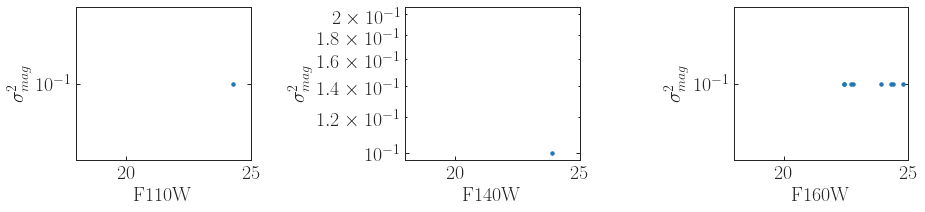

In [41]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 3))

mags=np.linspace(10, 27, 100)

for a in ax:
    #a.invert_yaxis()
    a.set_xlim([18, 25])
    a.set_ylabel(r'$\sigma^2_{mag}$')
    a.set_yscale('log')
ax[0].plot(obs_F110W[:,0], obs_F110W[:,1], '.')
ax[1].plot(obs_F140W[:,0], obs_F140W[:,1], '.')
ax[2].plot(obs_F160W[:,0], obs_F160W[:,1], '.')

ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')
plt.tight_layout()

(164, 2)
(58, 2)
(164, 2)
(92, 2)
(164, 2)
(131, 2)


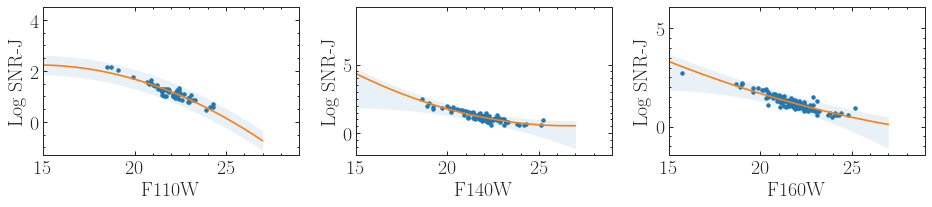

In [42]:
fig, ax=plt.subplots(ncols=3, figsize=(12, 3))

for a in ax:
    a.set_ylabel(r'Log SNR-J')
    a.set_xlim([15, 27])
    #a.set_ylim([0, 500])

ax[0].plot(obs_F110W[:,0], np.log10(snrs), '.')
ax[1].plot(obs_F140W[:,0], np.log10(snrs), '.')
ax[2].plot(obs_F160W[:,0], np.log10(snrs), '.')


p0=fit_polynomial(obs_F110W[:,0], np.log10(snrs), n=2, sigma=5)
ax[0].plot(mags, p0(mags))
ax[0].fill_between(mags, p0(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )


p1=fit_polynomial(obs_F140W[:,0], np.log10(snrs), n=2, sigma=5)
ax[1].plot(mags, p1(mags))
ax[1].fill_between(mags, p1(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )

nonnans160=dropnans(obs_F160W[:,0])
p2=fit_polynomial(obs_F160W[:,0], np.log10(snrs), n=2, sigma=5)
ax[2].plot(mags, p2(mags))
ax[2].fill_between(mags, p2(mags)+np.std(np.log10(snrs)), p0(mags)-np.std(np.log10(snrs)), alpha=0.1 )

for a in ax:
    a.set_xticks(np.arange(20, 30, 1), minor=True)
    a.set_yticks(np.arange(-1, 5, 0.5), minor=True)
    a.yaxis.set_ticks_position('both')
    a.xaxis.set_ticks_position('both')
    #a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor', direction='in')
    
ax[0].set_xlabel('F110W')
ax[1].set_xlabel('F140W')
ax[2].set_xlabel('F160W')

plt.tight_layout()

plt.savefig(wisps.OUTPUT_FIGURES+'/snr_fits.pdf')

In [43]:
polrealtions={'snr_F110W':p0, 'snr_F140W':p1, 'snr_F160W':p2, \
             'sp_F110W':p4, 'sigma_log_f110':  np.std(np.log10(snrs)),
              'sigma_log_f140':  np.std(np.log10(snrs)),
              'sigma_log_f160':  np.std(np.log10(snrs)),
              'sp_F140W':p5, 'sigma_sp_F140W':SIGMA1, 'sp_F160W':p6, 
              'sigma_sp_F160W':SIGMA2,
             'sigma_sp_F110W':SIGMA0 }

In [44]:
import pickle
with open(wisps.OUTPUT_FILES+'/polynomial_relations.pkl', 'wb') as file:
    pickle.dump(polrealtions,file)